In [236]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [209]:
df = pd.read_csv('data.csv')

Combine Date and Time columns into a single datetime column

In [210]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing 'kWh' suffix

In [211]:
df['Energy'] = df['Energy'].str.replace('kWh', '').astype(float)

In [212]:
df.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [213]:
df.sort_index(inplace=True)

In [214]:
df = df.resample('30min').last()

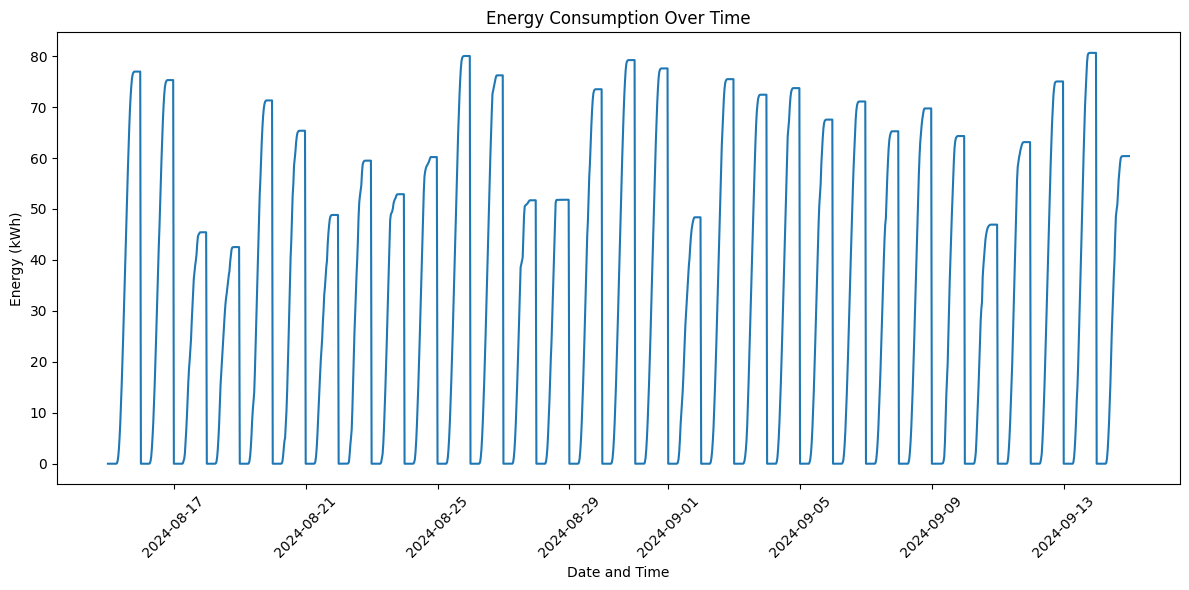

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.470848e+01
p-value                        2.872302e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.464000e+03
Critical Value (1%)           -3.434825e+00
Critical Value (5%)           -2.863516e+00
Critical Value (10%)          -2.567822e+00
dtype: float64


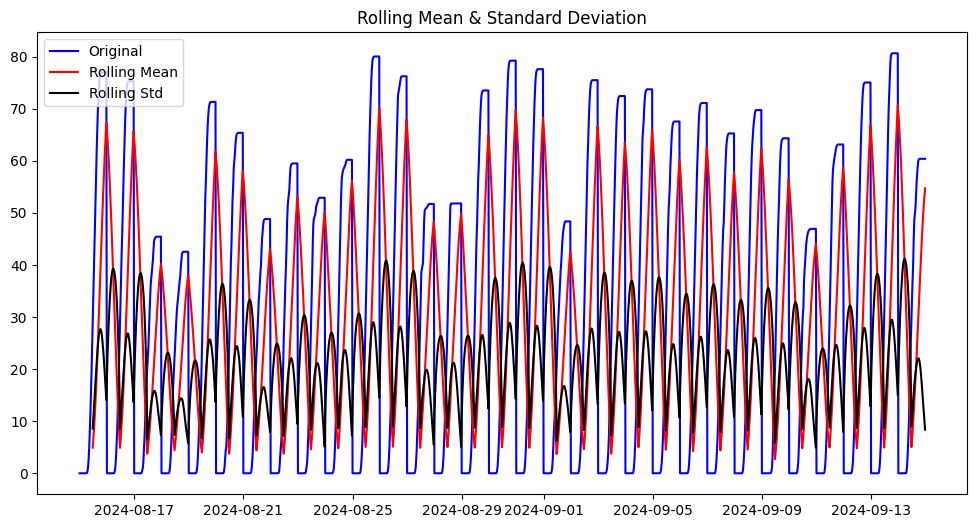

In [ ]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Plot rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    plt.figure(figsize=(12,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Check stationarity
check_stationarity(df['Energy'])


The test statistic (-14.71) is much lower (more negative) than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value (2.87e-27) is significantly smaller than 0.05, meaning we reject the null hypothesis of non-stationarity. Therefore, the data are considered stationary.

In [215]:
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter

In [118]:
df.head()

,Date,Time,Energy,minute,hour,day,month,dayofweek,quarter
DateTime,,,,,,,,,
2024-08-15 00:00:00,15/08/2024,12:25AM,0.0,0,0,15,8,3,3
2024-08-15 00:30:00,15/08/2024,12:55AM,0.0,30,0,15,8,3,3
2024-08-15 01:00:00,15/08/2024,1:25AM,0.0,0,1,15,8,3,3
2024-08-15 01:30:00,15/08/2024,1:55AM,0.0,30,1,15,8,3,3
2024-08-15 02:00:00,15/08/2024,2:25AM,0.0,0,2,15,8,3,3


In [216]:
# Select only numerical features
numerical_features = ['minute', 'hour', 'day', 'month', 'dayofweek', 'quarter', 'Energy']
df = df[numerical_features]

In [217]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].values)
        y.append(data.iloc[i + seq_length]['Energy'])
    return np.array(X), pd.Series(y, name='Energy', index=data.index[seq_length:])

seq_length = 48  # Adjust based on your needs
X, y = create_sequences(df, seq_length)


Split the data into training and testing sets (80% train, 20% test)

In [218]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create train and test DataFrames
train = pd.DataFrame({'Energy': y_train})
test = pd.DataFrame({'Energy': y_test})

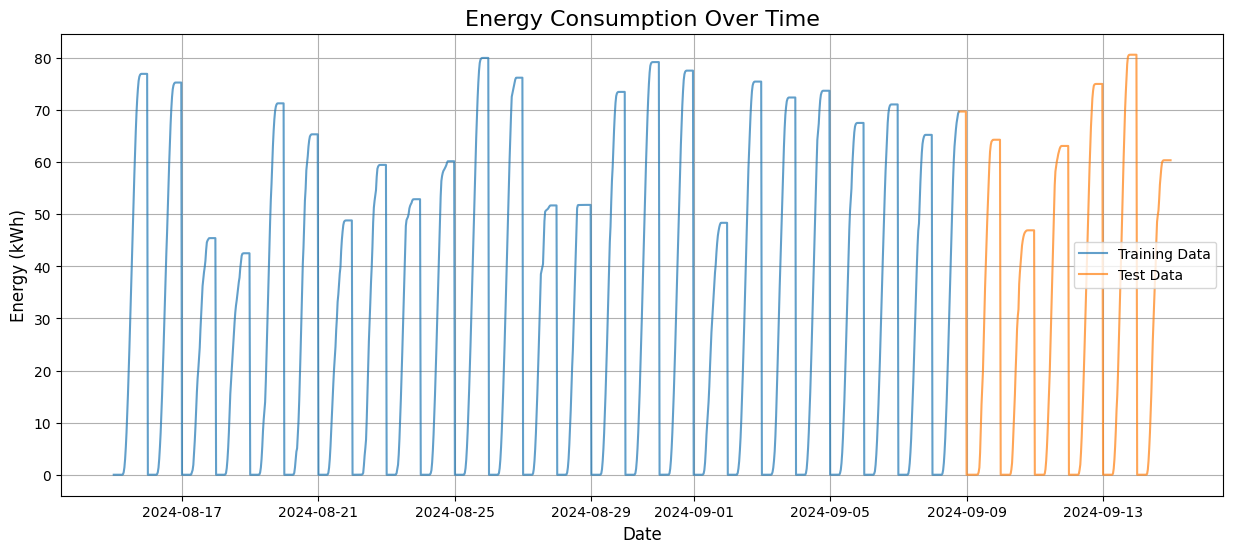

In [ ]:
def plot_feature_distributions(train, test, features):
    n_features = len(features)
    fig, axs = plt.subplots(n_features, 2, figsize=(15, 4*n_features))
    fig.suptitle('Feature Distributions in Training and Test Sets', fontsize=16)

    for i, feature in enumerate(features):
        sns.histplot(train[feature], kde=True, ax=axs[i, 0], color='blue', alpha=0.6)
        sns.histplot(test[feature], kde=True, ax=axs[i, 0], color='red', alpha=0.6)
        axs[i, 0].set_title(f'{feature} Distribution')
        axs[i, 0].legend(['Train', 'Test'])

        sns.boxplot(x=train[feature], ax=axs[i, 1], color='blue', width=0.4, positions=[0])
        sns.boxplot(x=test[feature], ax=axs[i, 1], color='red', width=0.4, positions=[1])
        axs[i, 1].set_title(f'{feature} Boxplot')
        axs[i, 1].set_xticklabels(['Train', 'Test'])

    plt.tight_layout()
    plt.show()

# Plot target variable
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['Energy'], label='Training Data', alpha=0.7)
plt.plot(test.index, test['Energy'], label='Test Data', alpha=0.7)
plt.title('Energy Consumption Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [237]:
input_shape = (seq_length, X.shape[2])

# Create the model
model = Sequential([
    Input(shape=input_shape),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [230]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 4359.5088 - val_loss: 2791.0115
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1544.1603 - val_loss: 1678.7717
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1203.8854 - val_loss: 1140.0361
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 866.2652 - val_loss: 1505.1543
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1923.3459 - val_loss: 1140.4587
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 944.2173 - val_loss: 1043.6265
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 782.2420 - val_loss: 1062.3455
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 680.9705 - val_loss: 880.3981
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 619.8200 - val_loss: 721.4751
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 606.5995 - val_loss: 580.3856
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 490.8078 - val_loss: 512.6979
Epoch 12

In [231]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [232]:
# Convert test_predictions to a pandas Series with the same index as test
test_predictions = pd.Series(test_predictions.flatten(), index=test.index, name='Predictions')


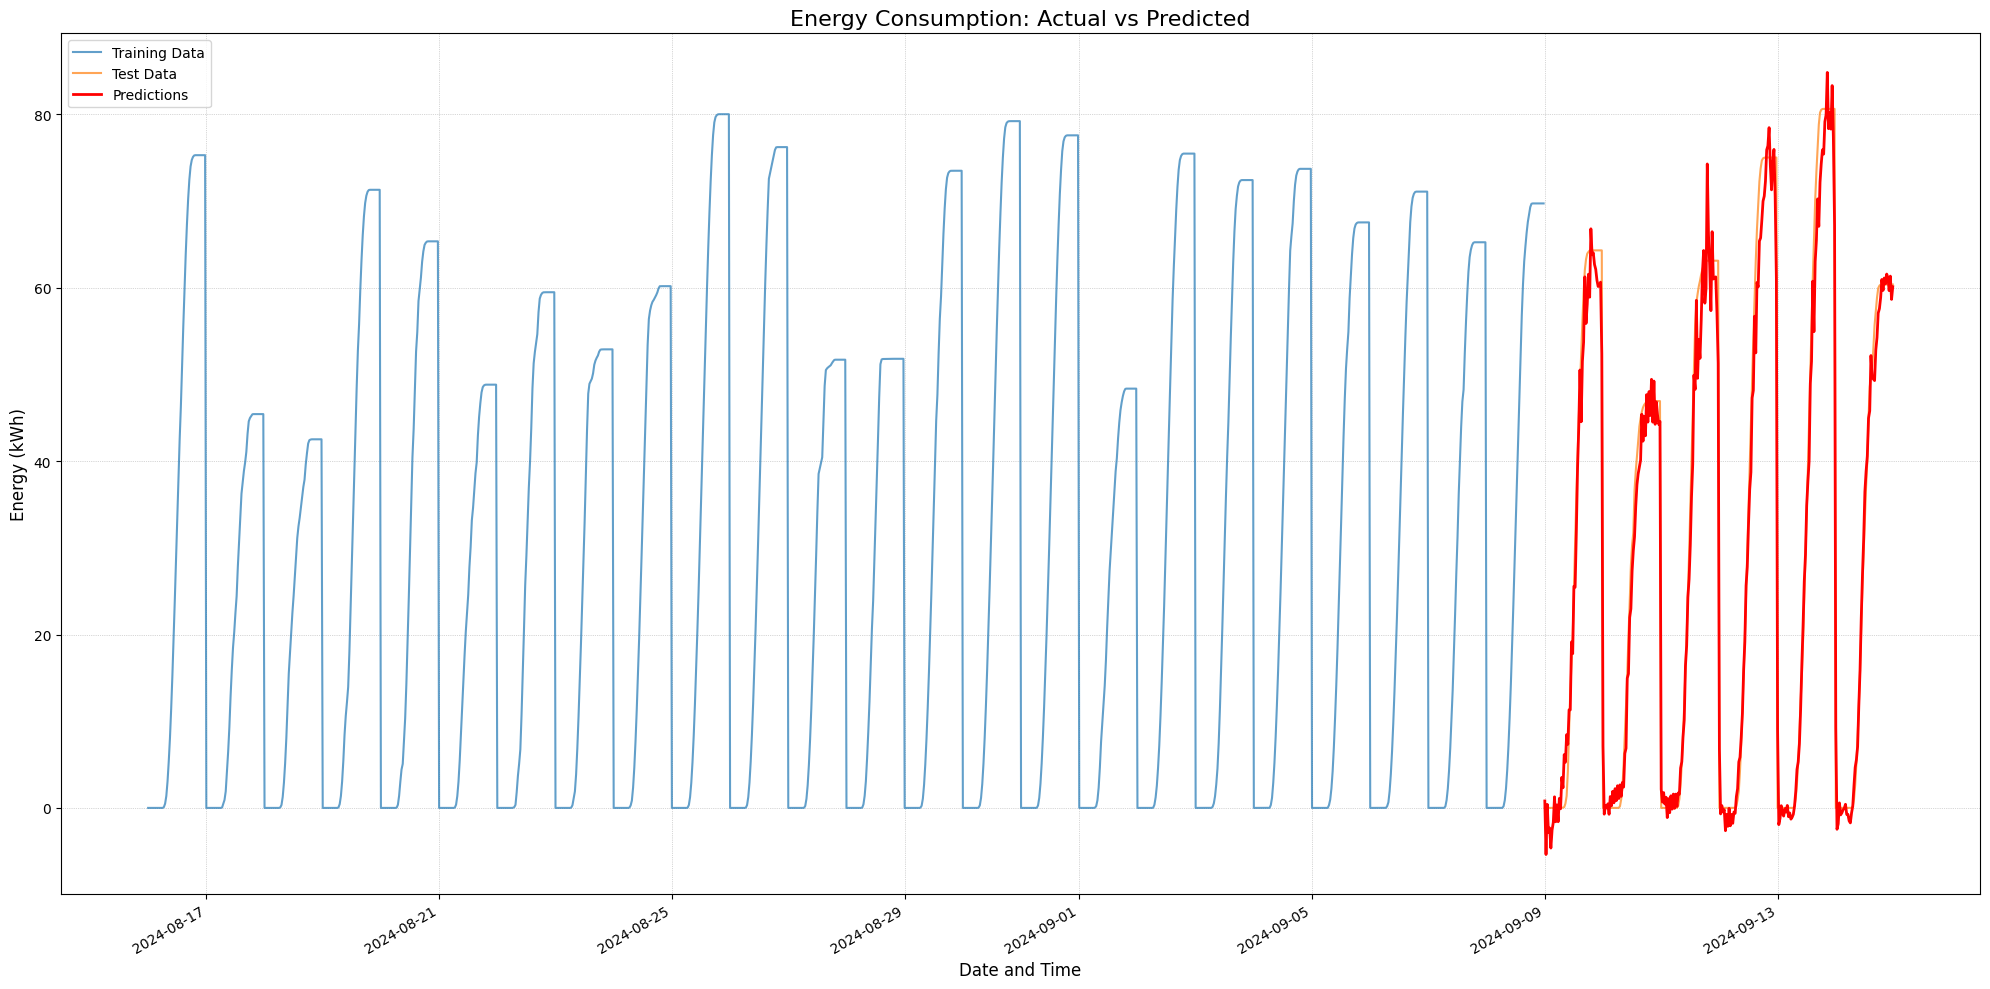

In [233]:
plt.figure(figsize=(20, 10))
plt.plot(train.index, train['Energy'], label='Training Data', alpha=0.7)
plt.plot(test.index, test['Energy'], label='Test Data', alpha=0.7)
plt.plot(test_predictions.index, test_predictions, label='Predictions', color='red', linewidth=2)
plt.title('Energy Consumption: Actual vs Predicted', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [234]:
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))


print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"Root Mean Square Error: {rmse:.2f} kWh")

Mean Absolute Error: 2.62 kWh
Root Mean Square Error: 3.73 kWh
